<a href="https://colab.research.google.com/github/abiB27/Practical-Tensorflow-with-Machine-Learning/blob/master/linear_regression_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install seaborn
!pip install tensorflow==2.0


     |████████████████████████████████| 86.3MB 40kB/s 
     |████████████████████████████████| 450kB 47.1MB/s 
     |████████████████████████████████| 3.8MB 47.9MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [0]:
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [0]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [0]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,sep=" ", na_values="?", skipinitialspace=True, comment='\t')

In [73]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [0]:
dataset = raw_dataset.copy()

In [75]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1:'USA', 2:'EUROPE', 3:'JAPAN'}.get(x))

In [78]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [79]:
#Convert categorical variable into dummy/indicator variables.
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,EUROPE,JAPAN,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
#Split the data into train and test

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

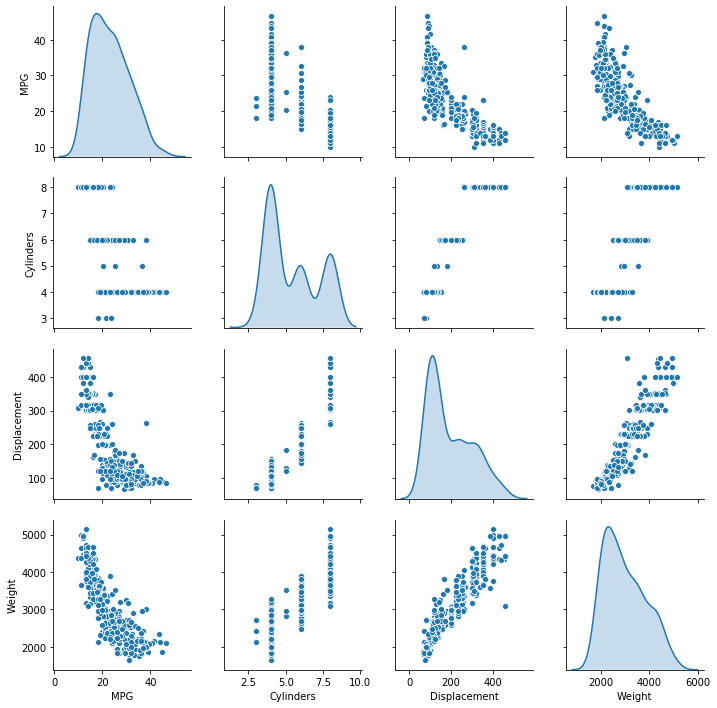

In [81]:
#inspect the data

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

##Kernel density estimation is a really useful statistical tool 
##if you want to visualize just the “shape” of some data, as a kind of continuous replacement for the discrete histogram. 

In [0]:
#Split features from labels
#Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [83]:
train_stats = train_dataset.describe().transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
EUROPE,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
JAPAN,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
## Normalize the data


def norm(x):
  return (x - train_stats['mean'] )/ train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#**Compilation**
Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. See: optimizers.
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: losses.
* A list of metrics. For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.



In [0]:
##SAMPLE CODE

# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# For a binary classification problem
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# For a mean squared error regression problem
model.compile(optimizer='rmsprop',
              loss='mse')

#Usage of metrics
A metric is a function that is used to judge the performance of your model. Metric functions are to be supplied in the metrics parameter when a model is compiled.

A metric function is similar to a loss function, except that the results from evaluating a metric are not used when training the model. 


In [0]:
##model


##model 1

def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  ## method to reach minimum error


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
  
  return model

In [0]:
model = build_model()

In [111]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [112]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.27866423],
       [-0.05769785],
       [-0.02917818],
       [-0.2999051 ],
       [-0.46984202],
       [ 0.00819466],
       [-0.52580094],
       [-0.25278205],
       [-0.06268743],
       [-0.33221754]], dtype=float32)

#**VERBOSE**
By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.

verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar like this:

progres_bar

verbose=2 will just mention the number of epoch like this:


```
# EPOCH 1/10
```



#**Usage of callbacks**
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.




In [113]:
##train model

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:581.6493,  mae:22.8016,  mse:581.6494,  val_loss:576.4342,  val_mae:22.6200,  val_mse:576.4342,  
....................................................................................................
Epoch: 100, loss:6.1675,  mae:1.7545,  mse:6.1675,  val_loss:8.5910,  val_mae:2.2263,  val_mse:8.5910,  
....................................................................................................
Epoch: 200, loss:5.4987,  mae:1.6234,  mse:5.4987,  val_loss:8.1603,  val_mae:2.1546,  val_mse:8.1603,  
....................................................................................................
Epoch: 300, loss:5.0310,  mae:1.5231,  mse:5.0310,  val_loss:8.1512,  val_mae:2.2479,  val_mse:8.1512,  
....................................................................................................
Epoch: 400, loss:4.5176,  mae:1.3928,  mse:4.5176,  val_loss:9.3158,  val_mae:2.2390,  val_mse:9.3158,  
..............................................................

In [119]:
hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch

hist.tail()






,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.851721,1.097712,2.851721,7.859347,2.262355,7.859347,995
996,2.818025,1.029530,2.818025,7.494817,2.109645,7.494817,996
997,2.711268,1.037480,2.711268,8.161423,2.274461,8.161424,997
998,2.918772,1.083119,2.918772,7.625393,2.147174,7.625393,998
999,2.864336,1.087619,2.864336,7.972011,2.122500,7.972011,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE[MPG]')

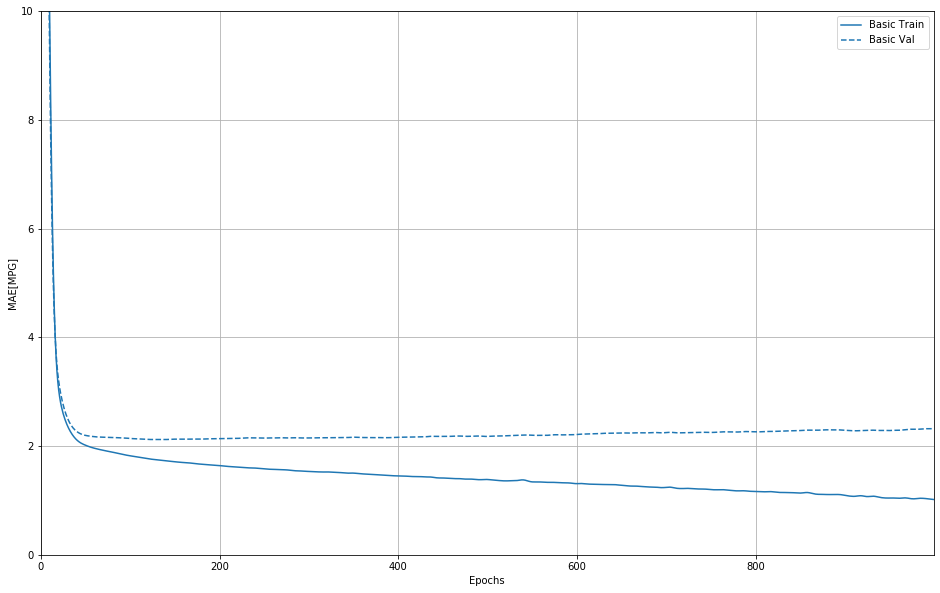

In [104]:
plotter.plot({'Basic':history}, metric = 'mae')
plt.ylim([0,10])
plt.ylabel('MAE[MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

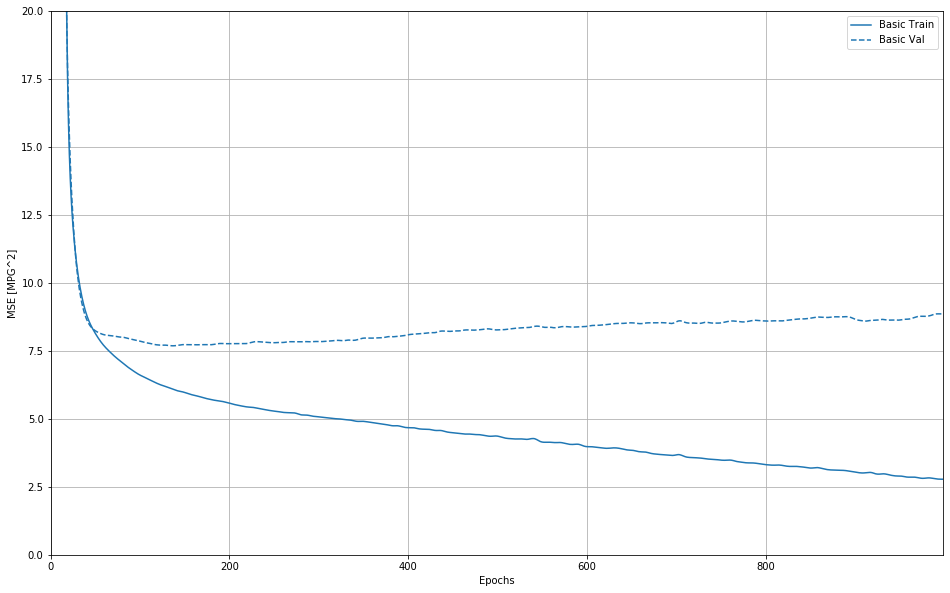

In [105]:
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0,20])
plt.ylabel('MSE [MPG^2]')

In [106]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0,callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:569.9311,  mae:22.6181,  mse:569.9311,  val_loss:575.1353,  val_mae:22.6986,  val_mse:575.1353,  
....................................................................................................
Epoch: 100, loss:6.4695,  mae:1.7967,  mse:6.4695,  val_loss:8.7861,  val_mae:2.2224,  val_mse:8.7861,  
.............................

#**EarlyStopping**
Stop training when a monitored quantity has stopped improving

* monitor: Quantity to be monitored.
* patience: Number of epochs with no improvement after which training will be stopped.

Text(0, 0.5, 'MAE [MPG]')

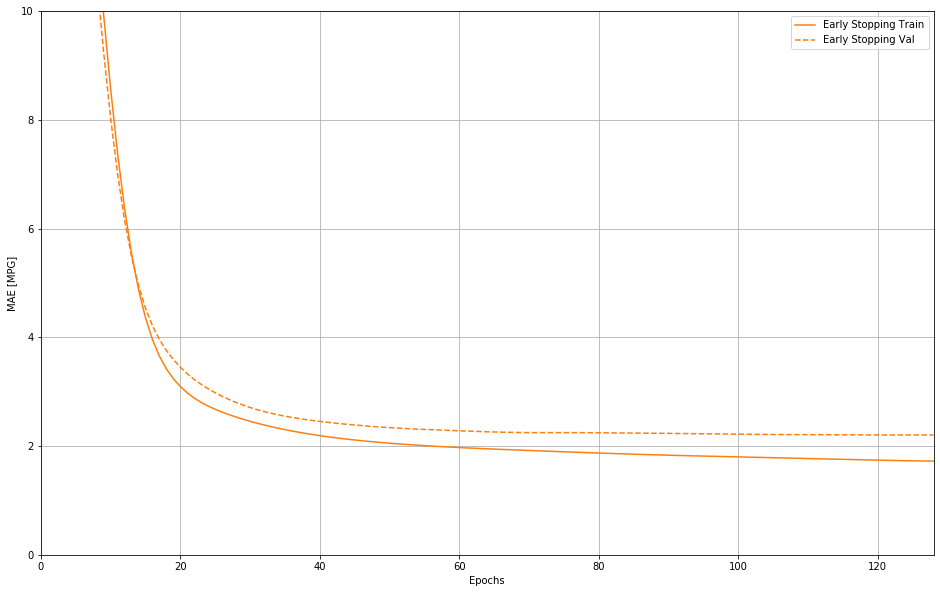

In [107]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [122]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=1)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 [==============================] - 0s 105us/sample - loss: 6.0354 - mae: 2.0089 - mse: 6.0354
Testing set Mean Abs Error:  2.01 MPG


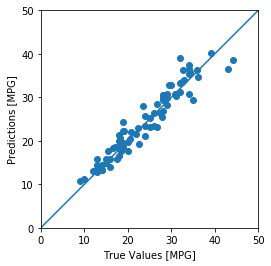

In [39]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

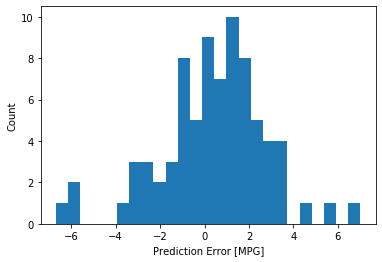

In [40]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

#Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).

* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
*When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
*If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
*Early stopping is a useful technique to prevent overfitting.